# COMP90051 Project 2

**Copyright statement:** This notebook is copyright University of Melbourne. 
It is licensed for the sole purpose of your assessment in COMP90051. 
You are not permitted to share or publish derived versions of this notebook, other than with COMP90051 staff for assessment.

***

The code block below imports the namespaces/functions/classes you may use in the project. 
Additional imports are not permitted.

In [296]:
# Do not edit. These are the only imports permitted.
import numpy as np
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt

# Type annotations
from numpy import ndarray
from numpy.random import Generator
from typing import List, Optional, Tuple, Callable

from sklearn.linear_model import LogisticRegression  # for Part 4

The base `MAB` class below defines a common interface for a contextual multi-armed bandit. 
Your bandit implementations in Parts 1-4 should inherit from this class.

In [297]:
class MAB(ABC):
    """Base class for a contextual multi-armed bandit (MAB)
    
    Parameters
    ----------
    n_arms : int
        Number of arms.
        
    rng : Generator, optional
        A `Generator` used as an internal source of randomness. If None, a 
        default `Generator` will be constructed using `np.random.default_rng`.
    """
    def __init__(self, n_arms: int, rng: Optional[Generator] = None) -> None:
        if not n_arms >= 0:
            raise ValueError("`n_arms` must be non-negative")
        self.n_arms = n_arms
        self.rng = np.random.default_rng(rng)
    
    @abstractmethod
    def play(self, context: Optional[ndarray] = None) -> int:
        """Play a round
        
        Parameters
        ----------        
        context : float numpy.ndarray, shape (n_arms, n_dims), optional
            An array of context vectors presented to the MAB. The 0-th 
            axis indexes the arms, and the 1-st axis indexes the features.
            Non-contextual bandits accept a context of None.
        
        Returns
        -------
        arm : int
            Integer index of the arm played this round. Should be in the set 
            {0, ..., n_arms - 1}.
        """
    
    @abstractmethod
    def update(self, arm: int, reward: float, context: Optional[ndarray] = None) -> None:
        """Update the internal state of the MAB after a play
        
        Parameters
        ----------
        arm : int
            Integer index of the played arm in the set {0, ..., n_arms - 1}.
            
        reward : float
            Reward received from the arm.
        
        context : float numpy.ndarray, shape (n_arms, n_dims), optional
            An array of context vectors that was presented to the MAB. The 
            0-th axis indexes the arms, and the 1-st axis indexes the 
            features. Non-contextual bandits accept a context of None.
        """
        if arm >= self.n_arms or arm < 0:
            raise ValueError("`arm` must be in the range "
                             "[0, {}]".format(self.n_arms - 1))

The function below implements off-policy evaluation as described in Appendix A of the project spec. 
You should use it—along with the provided dataset—to evaluate the bandits in Parts 1-4.

In [298]:
def offline_eval(mab: MAB, arms: ndarray, rewards: ndarray, contexts: ndarray, 
                 n_rounds: Optional[int] = None) -> ndarray:
    """Offline evaluation of a multi-armed bandit
    
    Parameters
    ----------
    mab : instance of MAB
        MAB to evaluate.
    
    arms : int ndarray, shape (n_events,) 
        Array containing the history of pulled arms, represented as integer 
        indices in the set {0, ..., mab.n_arms}
    
    rewards : float ndarray, shape (n_events,)
        Array containing the history of rewards. If a reward is missing, it 
        should be represented by `np.nan`.
    
    contexts : float ndarray, shape (n_events, n_arms, n_dims)
        Array containing the history of contexts presented to the arms. 
        The 0-th axis indexes the events in the history, the 1-st axis 
        indexes the arms and the 2-nd axis indexed the features.
        
    n_rounds : int, optional
        Number of matching events to evaluate the MAB on. If None, 
        continue evaluating until the historical events are exhausted.
    
    Returns
    -------
    matching_rewards : ndarray
        Rewards of matched events.
    """
    # Check types
    if not isinstance(mab, MAB):
        raise TypeError("`mab` must be an instance of MAB")
    arms = np.asarray(arms)
    rewards = np.asarray(rewards)
    contexts = np.asarray(contexts)
    if n_rounds is not None and n_rounds < 0:
        raise ValueError("`n_rounds` must be non-negative")
    
    # Check array dimensions
    if arms.ndim != 1:
        raise ValueError("`arms` must be a 1D array")
    if rewards.ndim != 1:
        raise ValueError("`rewards` must be a 1D array")
    if contexts.ndim != 3:
        raise ValueError("`contexts` must be a 3D array")
    if not (arms.shape[0] == rewards.shape[0] == contexts.shape[0]):
        raise ValueError("first dimension of input arrays are inconsistent")
    if contexts.shape[1] != mab.n_arms:
        raise ValueError("`contexts` has inconsistent second dimension")
    if arms.max() >= mab.n_arms or arms.min() < 0:
        raise ValueError("`arms` contains ids that are out-of-range")
    
    matched_ctr = 0
    matched_ids = list()
    for i in range(arms.size):
        if n_rounds is not None and matched_ctr >= n_rounds: # Note: fixed
            break
        arm_id = mab.play(contexts[i])
        if arm_id == arms[i]:
            reward = None if np.isnan(rewards[i]) else rewards[i]
            mab.update(arm_id, reward, contexts[i])
            matched_ctr += 1
            matched_ids.append(i)
    
    return rewards[matched_ids], matched_ids

Please define any static functions/variables (used across multiple tasks) in the code block below.

In [299]:
rng = np.random.default_rng(90051)  # Random generator used throughout

# Define additional static functions/variables here, if required


## Part 1: Thompson sampling MAB

In [300]:
class TS(MAB):
    """Thompson sampling MAB with a Beta-Bernoulli reward model

    Parameters
    ----------
    n_arms : int
        Number of arms.

    alpha0: float, optional
        positive real prior hyperparameter

    beta0: float, optional
        positive real prior hyperparameter
    
    rng : Generator, optional
        A `Generator` used as an internal source of randomness. If None, a 
        default `Generator` will be constructed using `np.random.default_rng`.
    """
    def __init__(self, n_arms: int, alpha0: float = 1.0, beta0: float = 1.0, 
                 rng: Optional[Generator] = None) -> None:
        ... # implement or remove this method
        super().__init__(n_arms, rng)
        self.alpha_array = np.full(n_arms, alpha0)
        self.beta_array = np.full(n_arms, beta0)
        self.mean_array = np.full(n_arms, alpha0 / (alpha0 + beta0))
        
    def play(self, context: Optional[ndarray] = None) -> int:
        ... # implement or remove this method
        super().play(context=None)
        #return np.random.choice(np.flatnonzero(self.mean_array == self.mean_array.max()))
        return self.rng.choice(np.flatnonzero(self.mean_array == self.mean_array.max()))
        
    def update(self, arm: int, reward: float, context: Optional[ndarray] = None) -> None:
        ... # implement or remove this method
        super().update(arm, reward, context=None)
        if reward == 1:
            self.alpha_array[arm] += 1
        else:
            self.beta_array[arm] += 1
            
        self.mean_array[arm] = self.alpha_array[arm] / (self.alpha_array[arm] + self.beta_array[arm])

In [301]:
# Load dataset here
dataset = np.genfromtxt('dataset1.txt', dtype=np.int64)
arms = dataset[:, 0]
rewards = dataset[:, 1].astype(float)
contexts = dataset[:,2::].astype(float).reshape(-1,10,10)

In [302]:
rng = np.random.default_rng(90051)
mab = TS(10, alpha0=1.0, beta0=1.0, rng=rng)
TS_rewards, TS_ids = offline_eval(mab, arms, rewards, contexts, n_rounds=800)
print('TS average reward', np.mean(TS_rewards))

TS average reward 0.26625


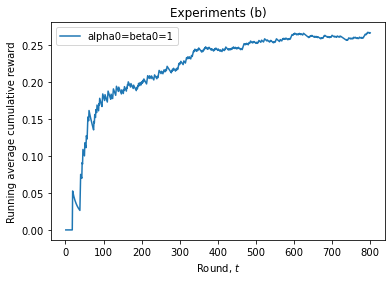

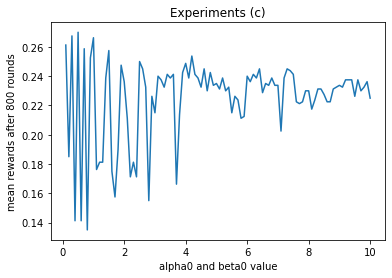

When the mean rewards for 800 rounds is largest, alpha0=beta0=  0.5
The largest mean reward value is  0.27


In [303]:
# Use additional cells here for experimentation
def plot_results(results, label=None):
    tround = np.arange(1, results.size + 1)
    cumsum = np.cumsum(results) / tround
    plt.plot(tround, cumsum, label=label)

# experiments (b)
plot_results(TS_rewards, label="alpha0=beta0=1")
plt.legend()
plt.xlabel('Round, $t$')
plt.ylabel('Running average cumulative reward')
plt.title('Experiments (b)')
plt.show()

# experiments (c)
hyper_parameter = np.linspace(0.1, 10, 100)
mean_value = []
for par in hyper_parameter:
    rng = np.random.default_rng(90051)
    mab = TS(10, alpha0=par, beta0=par, rng=rng)
    the_TS_rewards, the_TS_ids = offline_eval(mab, arms, rewards, contexts, n_rounds=800)
    mean_value.append(np.mean(the_TS_rewards))
    


plt.plot(hyper_parameter, mean_value)
plt.xlabel('alpha0 and beta0 value')
plt.ylabel('mean rewards after 800 rounds')
plt.title('Experiments (c)')
plt.show()


print('When the mean rewards for 800 rounds is largest, alpha0=beta0= ', hyper_parameter[np.argmax(np.array(mean_value))])
print('The largest mean reward value is ', np.array(mean_value).max())

## Part 2: Thompson sampling contextual MAB with linear payoffs

In [304]:
class LinTS(MAB):
    """Thompson sampling contextual MAB with a ridge regression reward model

    Parameters
    ----------
    n_arms : int
        Number of arms.
    
    n_dims : int
        Number of dimensions for each arm's context.
        
    v: float, optional
        Positive real explore-exploit parameter
    
    rng : Generator, optional
        A `Generator` used as an internal source of randomness. If None, a 
        default `Generator` will be constructed using `np.random.default_rng`.
    """    
    def __init__(self, n_arms: int, n_dims: int, v: float = 1.0, 
                 rng: Optional[Generator] = None) -> None:
        ... # implement or remove this method
        super().__init__(n_arms, rng)
        self.n_dims = n_dims
        self.v = v
        self.B = np.eye(n_dims)
        self.mu_bar = np.zeros(n_dims)
        self.f = np.zeros(n_dims)
        
    def play(self, context: Optional[ndarray] = None) -> int:
        ... # implement or remove this method
        super().play(context)
        mu = self.rng.multivariate_normal(self.mu_bar, (self.v)**2 * np.linalg.inv(self.B), size=1).ravel()
        multi_result = np.zeros(self.n_dims)
        for i in range(self.n_dims):
            multi_result[i] = context[i].T @ mu
            
        return self.rng.choice(np.flatnonzero(multi_result == multi_result.max()))
    
    def update(self, arm: int, reward: float, context: Optional[ndarray] = None) -> None:
        ... # implement or remove this method
        super().update(arm, reward, context)
        self.B = self.B + context[arm] @ context[arm].T
        self.f = self.f + context[arm] * reward
        self.mu_bar = np.linalg.inv(B) @ self.f

In [305]:
rng = np.random.default_rng(90051)
mab = LinTS(10, 10, v=1.0, rng=rng)
LinTS_rewards, LinTS_ids = offline_eval(mab, arms, rewards, contexts, n_rounds=800)
print('LinTS average reward', np.mean(LinTS_rewards))

LinTS average reward 0.32125


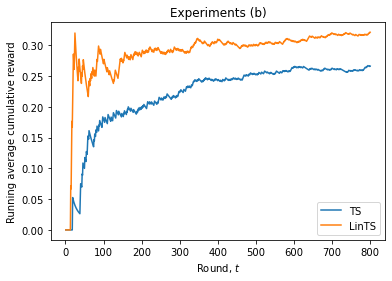

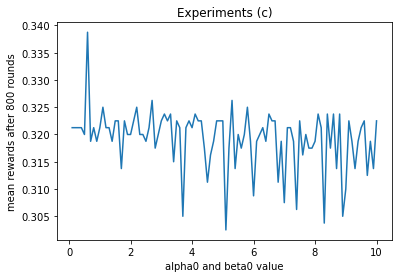

When the mean rewards for 800 rounds is largest, v=  0.6
The largest mean reward value is  0.33875


In [306]:
# Use additional cells here for experimentation

# experiments (b)
plot_results(TS_rewards, label="TS")
plot_results(LinTS_rewards, label="LinTS")
plt.legend()
plt.xlabel('Round, $t$')
plt.ylabel('Running average cumulative reward')
plt.title('Experiments (b)')
plt.show()

# experiments (c)
v_parameter = np.linspace(0.1, 10, 100)
mean_value = []
for par in v_parameter:
    rng = np.random.default_rng(90051)
    mab = LinTS(10, 10, par, rng=rng)
    the_LinTS_rewards, the_LinTS_ids = offline_eval(mab, arms, rewards, contexts, n_rounds=800)
    mean_value.append(np.mean(the_LinTS_rewards))
    

plt.plot(v_parameter, mean_value)
plt.xlabel('alpha0 and beta0 value')
plt.ylabel('mean rewards after 800 rounds')
plt.title('Experiments (c)')
plt.show()


print('When the mean rewards for 800 rounds is largest, v= ', v_parameter[np.argmax(np.array(mean_value))])
print('The largest mean reward value is ', np.array(mean_value).max())

## Part 3: Thompson sampling MABs with fair exposure

In [307]:
class FairXTS(TS):
    """FairX Thompson sampling MAB with a Beta-Bernoulli reward model

    Parameters
    ----------
    n_arms : int
        Number of arms.

    c : float, optional
        Scaling factor for expected reward in exponential merit function
    
    alpha0: float, optional
        Positive real prior hyperparameter.

    beta0: float, optional
        Positive real prior hyperparameter.
    
    rng : Generator, optional
        A `Generator` used as an internal source of randomness. If None, a 
        default `Generator` will be constructed using `np.random.default_rng`.
    """
    def __init__(self, n_arms: int, c: float = 1.0, alpha0: float = 1.0, 
                 beta0: float = 1.0, rng: Optional[Generator] = None) -> None:
        ... # implement or remove this method
        super().__init__(n_arms, alpha0, beta0, rng)
        self.c = c
        arm_num = [i for i in range(n_arms)]
        self.arm_num = arm_num
    
    def play(self, context: Optional[ndarray] = None) -> int:
        ... # implement or remove this method
        super().play(context=None)
        exp_prob = []
        denom = sum([np.exp(self.c * i) for i in self.mean_array])
        for j in self.mean_array:
            exp_prob.append(np.exp(self.c * j) / denom)
        
        return self.rng.choice(self.arm_num, 1, p=exp_prob)[0]
    
    def update(self, arm: int, reward: float, context: Optional[ndarray] = None) -> None:
        ... # implement or remove this method
        super().update(arm, reward, context=None)

In [308]:
rng = np.random.default_rng(90051)
mab = FairXTS(10, c=1.0, alpha0=1.0, beta0=1.0, rng=rng)
FairXTS_rewards, FairXTS_ids = offline_eval(mab, arms, rewards, contexts, n_rounds=800)
print('FairX-TS average reward', np.mean(FairXTS_rewards))

FairX-TS average reward 0.10125


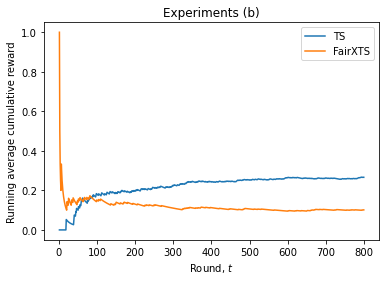

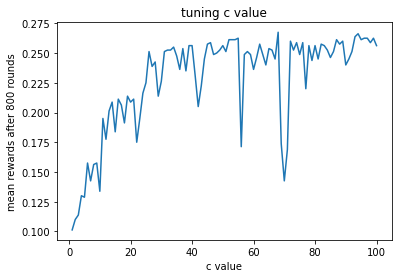

When the mean rewards for 800 rounds is largest, v=  68.0
The largest mean reward value is  0.2675


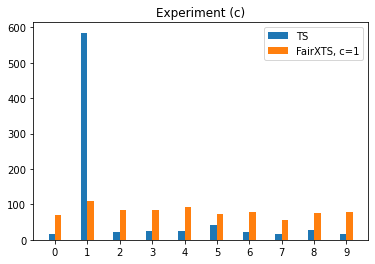

Answer for experiment part (e): We can see that in TS method, the arm 1 frequency is much greater than FairXTS method.
The differences of frequency in other arms except arm 1 in TS method are really small.
However, for the FairXTS method, the frequency of arm 1 is much smaller than arm 1 in TS method
Although arm 1 has the largest frequency in the FairXTS method, the differences between arm 1 and other arms are much smaller.


In [309]:
# Use additional cells here for experimentation

# experiments (b)
plot_results(TS_rewards, label="TS")
plot_results(FairXTS_rewards, label="FairXTS")
plt.legend()
plt.xlabel('Round, $t$')
plt.ylabel('Running average cumulative reward')
plt.title('Experiments (b)')
plt.show()

# experiment (c)

# firstly, we should tune the parameter c
v_parameter = np.linspace(1, 100, 100)
mean_value = []
for par in v_parameter:
    rng = np.random.default_rng(90051)
    mab = FairXTS(10, par, 1.0, 1.0, rng=rng)
    the_FairXTS_rewards, the_FairXTS_ids = offline_eval(mab, arms, rewards, contexts, n_rounds=800)
    mean_value.append(np.mean(the_FairXTS_rewards))
    
plt.plot(v_parameter, mean_value)
plt.xlabel('c value')
plt.ylabel('mean rewards after 800 rounds')
plt.title('tuning c value')
plt.show()

print('When the mean rewards for 800 rounds is largest, v= ', v_parameter[np.argmax(np.array(mean_value))])
print('The largest mean reward value is ', np.array(mean_value).max())

# Plot the number of pulls for each arm
n_arm = 10
arm_num_TS = {}
for i in range(n_arm):
    arm_num_TS[i] = 0
    
for j in the_TS_ids:
    arm_num_TS[arms[j]] += 1

arm_num_FairXTS_c1 = {}
for i in range(n_arm):
    arm_num_FairXTS_c1[i] = 0

for j in FairXTS_ids:
    arm_num_FairXTS_c1[arms[j]] += 1
    
arm_num_FairXTS_ctuning = {}

rng = np.random.default_rng(90051)
mab = FairXTS(10, v_parameter[np.argmax(np.array(mean_value))], 1.0, 1.0, rng=rng)
max_FairXTS_rewards, max_FairXTS_ids = offline_eval(mab, arms, rewards, contexts, n_rounds=800)
for i in range(n_arm):
    arm_num_FairXTS_ctuning[i] = 0

for j in max_FairXTS_ids:
    arm_num_FairXTS_ctuning[arms[j]] += 1

index, TS_l, FTS_c1, FTS_ctuning = [], [], [], []
for k in range(n_arm):
    index.append(k)
    TS_l.append(arm_num_TS[k])
    FTS_c1.append(arm_num_FairXTS_c1[k])
    FTS_ctuning.append(arm_num_FairXTS_ctuning[k])
    
plt.bar(np.arange(n_arm)-0.1, TS_l, width=0.2, label='TS')
plt.bar(np.arange(n_arm)+0.1, FTS_c1, width=0.2, label='FairXTS, c=1')
#plt.bar(np.arange(n_arm)+0.2, FTS_ctuning, width=0.2, label='FairXTS, c=68 (after tuning)')
plt.xticks(index)
plt.title('Experiment (c)')
plt.legend()
plt.show()
 
print('Answer for experiment part (e): We can see that in TS method, the arm 1 frequency is much greater than FairXTS method.')
print('The differences of frequency in other arms except arm 1 in TS method are really small.')
print('However, for the FairXTS method, the frequency of arm 1 is much smaller than arm 1 in TS method')
print('Although arm 1 has the largest frequency in the FairXTS method, the differences between arm 1 and other arms are much smaller.')

In [310]:
class FairXLinTS(LinTS):
    """FairX Thompson sampling contextual MAB with a ridge regression reward model

    Parameters
    ----------
    n_arms : int
        Number of arms.
    
    n_dims : int
        Number of dimensions for each arm's context.
    
    c : float, optional
        Scaling factor for expected reward in exponential merit function
    
    v: float, optional
        Positive real explore-exploit parameter
    
    rng : Generator, optional
        A `Generator` used as an internal source of randomness. If None, a 
        default `Generator` will be constructed using `np.random.default_rng`.
    """
    def __init__(self, n_arms: int, n_dims: int, c: float = 1.0, 
                 v: float = 1.0, rng: Optional[Generator] = None) -> None:
        ... # implement or remove this method
        super().__init__(n_arms, n_dims, v, rng)
        self.c = c
        arm_num = [i for i in range(n_arms)]
        self.arm_num = arm_num
    
    def play(self, context: Optional[ndarray] = None) -> int:
        ... # implement or remove this method
        mu = self.rng.multivariate_normal(self.mu_bar, (self.v)**2 * np.linalg.inv(self.B), size=1).ravel()
        multi_result = np.zeros(self.n_dims)
        for i in range(self.n_dims):
            multi_result[i] = context[i].T @ mu
            
        exp_prob = []
        denom = [self.c * i for i in multi_result]
        denom_sum = sum(np.exp(k - max(denom)) for k in denom)
        for j in denom:
            exp_prob.append(np.exp(j - max(denom)) / denom_sum)

        return self.rng.choice(self.arm_num, 1, p=exp_prob)[0]
    
    def update(self, arm: int, reward: float, context: Optional[ndarray] = None) -> None:
        ... # implement or remove this method
        super().update(arm, reward, context)

In [311]:
rng = np.random.default_rng(90051)
mab = FairXLinTS(10, 10, c=1.0, v=1.0, rng=rng)
FairXLinTS_rewards, FairXLinTS_ids = offline_eval(mab, arms, rewards, contexts, n_rounds=800)
print('FairX-LinTS average reward', np.mean(FairXLinTS_rewards))

FairX-LinTS average reward 0.32125


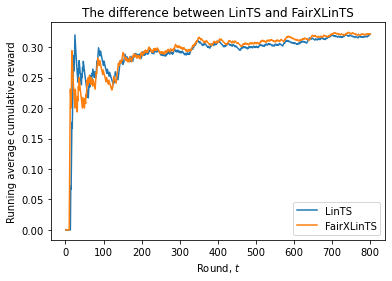

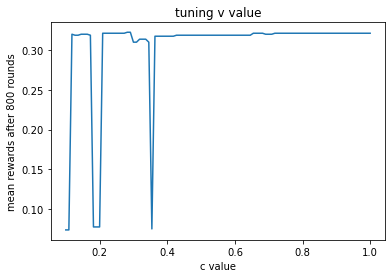

When the mean rewards for 800 rounds is largest, v=  0.28181818181818186
The largest mean reward value is  0.3225


In [312]:
# Use additional cells here for experimentation

# experiments (e)
plot_results(LinTS_rewards, label="LinTS")
plot_results(FairXLinTS_rewards, label="FairXLinTS")
plt.legend()
plt.xlabel('Round, $t$')
plt.ylabel('Running average cumulative reward')
plt.title('The difference between LinTS and FairXLinTS')
plt.show()

# tuning c value
v_parameter = np.linspace(0.1, 1, 100)
mean_value = []
for par in v_parameter:
    rng = np.random.default_rng(90051)
    mab = FairXLinTS(10, 10, par, 1.0, rng=rng)
    the_FairXLinTS_rewards, the_FairXLinTS_ids = offline_eval(mab, arms, rewards, contexts, n_rounds=800)
    mean_value.append(np.mean(the_FairXLinTS_rewards))
    
plt.plot(v_parameter, mean_value)
plt.xlabel('c value')
plt.ylabel('mean rewards after 800 rounds')
plt.title('tuning v value')
plt.show()

print('When the mean rewards for 800 rounds is largest, v= ', v_parameter[np.argmax(np.array(mean_value))])
print('The largest mean reward value is ', np.array(mean_value).max())


## Task 4: SquareCB contextual MAB with a logistic regression oracle

In [313]:
class SquareCB(MAB):
    """SquareCB contextual MAB with a logistic regression oracle

    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.
    
    gamma : float, optional
        Learning rate parameter.
    
    rng : Generator, optional
        A `Generator` used as an internal source of randomness. If None, a 
        default `Generator` will be constructed using `np.random.default_rng`.
    """
    def __init__(self, n_arms: int, n_dims: int, gamma: float = 1.0, 
                 rng: Optional[Generator] = None) -> None:
        ... # implement or remove this method
        super().__init__(n_arms, rng)
        self.n_dims = n_dims
        self.gamma = gamma 
        self.model = [0 for i in range(n_arms)]
        self.y_bar = np.zeros(n_arms)
        self.arm_num = [i for i in range(n_arms)]
        self.every_arm_sample = [[] for i in range(n_arms)]
            
    def play(self, context: Optional[ndarray] = None) -> int:
        ... # implement or remove this method
        super().play(context)
        mu = self.n_arms
        if self.model == [0 for i in range(self.n_arms)]:
            a = rng.choice([i for i in range(self.n_arms)])
            return a
        else:
            for i in range(self.n_arms):
                if self.model[i] == 0:
                    # set the initial score to 0
                    self.y_bar[i] = 0
                else:
                    self.y_bar[i] = self.model[i].score([k[0] for k in self.every_arm_sample[i]], [k[1] for k in self.every_arm_sample[i]])

            b_t = self.rng.choice(np.flatnonzero(self.y_bar == self.y_bar.min()))
            prob_array = np.zeros(self.n_arms)
            for j in range(self.n_arms):
                if j != b_t:
                    prob_array[j] = 1 / (mu + self.gamma * (self.y_bar[j] - self.y_bar[b_t]))
                    
            # because right now only prob_array[b_t] = 0, so we can calculate the sum of prob_array directly
            prob_array[b_t] = 1 - sum(prob_array)
            return self.rng.choice(self.arm_num, 1, p=prob_array)[0]  
    
    def update(self, arm: int, reward: float, 
               context: Optional[ndarray] = None) -> None:
        ... # implement or remove this method
        super().update(arm, reward, context)
        if self.model[arm] != 0:
            pred_value = self.model[arm].predict([context[arm]])[0]
            loss = (pred_value - reward) ** 2
            # if loss = 0 and reward = 1, the value is 1 (otherwise the value is 0)
            self.every_arm_sample[arm].append(tuple([context[arm], (1 - loss) * reward]))
        
            LR = LogisticRegression()
            X = []
            y = []
            for i in self.every_arm_sample[arm]:
                X.append(i[0])
                y.append(i[1])
            
            LR.fit(X, y)
            self.model[arm] = LR
            
        else:
            self.every_arm_sample[arm].append(tuple([context[arm], reward]))
            X = []
            y = []
            for i in self.every_arm_sample[arm]:
                X.append(i[0])
                y.append(i[1])
            if 0 in y and 1 in y:
                LR = LogisticRegression()
                LR.fit(X, y)
                self.model[arm] = LR
            

In [314]:
rng = np.random.default_rng(90051)
mab = SquareCB(10, 10, gamma=18.0, rng=rng)
SquareCB_rewards, SquareCB_ids = offline_eval(mab, arms, rewards, contexts, n_rounds=800)
print('SquareCB average reward', np.mean(SquareCB_rewards))

SquareCB average reward 0.08875


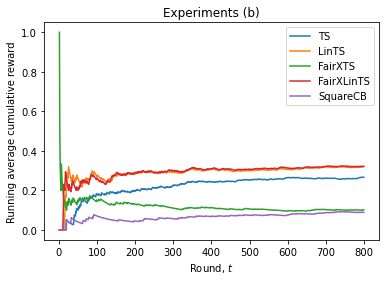

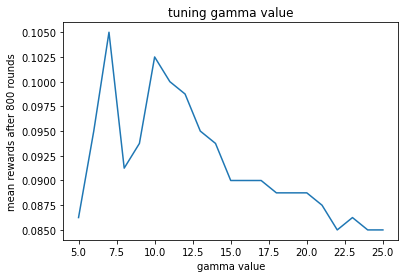

When the mean rewards for 800 rounds is largest, gamma=  7.0
The largest mean reward value is  0.105


In [315]:
# Use additional cells here for experimentation

# experiment (b)
plot_results(TS_rewards, label="TS")
plot_results(LinTS_rewards, label="LinTS")
plot_results(FairXTS_rewards, label="FairXTS")
plot_results(FairXLinTS_rewards, label="FairXLinTS")
plot_results(SquareCB_rewards, label="SquareCB")
plt.legend()
plt.xlabel('Round, $t$')
plt.ylabel('Running average cumulative reward')
plt.title('Experiments (b)')
plt.show()

# experiment (c): tuning gamma value
gamma_parameter = np.linspace(5, 25, 21)
mean_value = []
for par in gamma_parameter:
    rng = np.random.default_rng(90051)
    mab = SquareCB(10, 10, gamma=par, rng=rng)
    the_SquareCB_rewards, the_SquareCB_ids = offline_eval(mab, arms, rewards, contexts, n_rounds=800)
    mean_value.append(np.mean(the_SquareCB_rewards))
    
plt.plot(gamma_parameter, mean_value)
plt.xlabel('gamma value')
plt.ylabel('mean rewards after 800 rounds')
plt.title('tuning gamma value')
plt.show()

print('When the mean rewards for 800 rounds is largest, gamma= ', gamma_parameter[np.argmax(np.array(mean_value))])
print('The largest mean reward value is ', np.array(mean_value).max())